In contrast to the previous notebook, here, we will make use of the convolutional layer (CNN) to construct a tineVGG-like network to improve image classification. Convolutional layers have been known to learn the patterns present in the image data that fully-connected networks (with or without non-linear activations) are unable to learn efficiecntly and accurately within  feasible time and computation requirement.

In [2]:
import torch, torchvision
torch.__version__, torchvision.__version__

('2.0.0+cu118', '0.15.1+cu118')

In [3]:
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [4]:
from timeit import default_timer as timer

#### Getting torchvision dataset
`torchvision` provides some datasets that we can import to train our models. Here, we will use FashionMNIST dataset for demonstration. The returned variable is of type `Dataset` and has both features and the label of the sample at each index of the dataset.

In [5]:
train_data = torchvision.datasets.FashionMNIST(root="data",
                                               train=True, # download only training dataset
                                               download=True,
                                               transform=torchvision.transforms.ToTensor(),
                                               target_transform=None)

test_data = torchvision.datasets.FashionMNIST(root="data",
                                               train=False, # download only test dataset
                                               download=True,
                                               transform=torchvision.transforms.ToTensor(),
                                               target_transform=None)
class_names = train_data.classes

In [6]:
first_image, first_targe_label = train_data[0]
first_image.shape, first_targe_label

(torch.Size([1, 28, 28]), 9)

In [7]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1eeeaa617b0>,
 <torch.utils.data.dataloader.DataLoader at 0x1eeeaa61870>)

Let's see how to interact with the dataloader. As mentioned before, `DataLoader` turns our dataset into a Python iterable.

In [8]:
len(train_dataloader), len(test_dataloader)

(938, 157)

In [9]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch

(torch.Size([64, 1, 28, 28]),
 tensor([2, 8, 8, 9, 6, 0, 7, 8, 4, 3, 9, 3, 0, 5, 4, 3, 6, 1, 6, 1, 0, 4, 2, 4,
         7, 5, 1, 8, 2, 4, 1, 6, 8, 0, 4, 9, 7, 5, 0, 8, 0, 8, 3, 3, 2, 7, 2, 8,
         0, 7, 1, 1, 1, 2, 7, 5, 6, 8, 5, 9, 5, 1, 1, 9]))

Turns out, the `DataLoader` class converts the torchvision dataset features into the shape of B x C x H x W.

#### Build a Convoluational Neural Network.
Here, we will attempt to make classification of images based on CNN layers. We will create multiple CNN blocks such that they can be stacked one after the other.

In [10]:
class FashionMNIST_CNN_classifier(torch.nn.Module):
    """
    A torch model that looks similar to tiny VGGNet.
    """
    def __init__(self, in_channels: int, hidden_units : int, output_shape : int):
        super().__init__()
        
        self.conv_block_1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels,
                            out_channels=hidden_units,
                            kernel_size=3,
                            stride=1,
                            padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=hidden_units,
                            out_channels=hidden_units,
                            kernel_size=3,
                            stride=1,
                            padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=hidden_units,
                            out_channels=hidden_units,
                            kernel_size=3,
                            stride=1,
                            padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=hidden_units,
                            out_channels=hidden_units,
                            kernel_size=3,
                            stride=1,
                            padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        self.classifier_layer = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=  10 * 7 * 7, # calculated by printing the output of the previous block
                            out_features=output_shape)
        )

        

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        return self.classifier_layer(self.conv_block_2(self.conv_block_1(x)))

#### Training
Train the network using `DataLoader` object. The training loop algorithm looks as below:<br>
- Loop through epochs.
    - for training batch 0 to ...
        - calculate `training_loss` for this batch using loss function.
        - calculate gradients using `loss.backward()`.
        - update parameters using `optimizer.step()`.
    - for testing batch 0 to ...
        - calculate `test_loss` for this batch.
        

In [11]:
from helper_functions import accuracy_fn
from utils import print_training_time, set_seeds

from tqdm import tqdm

In [12]:
len(train_dataloader)

938

Checking output format before training.


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
# create a classifier.
# shape of a FashionMNIST image is 28*28 and there are 10 different output labels.
set_seeds(42)
_classifier = FashionMNIST_CNN_classifier(in_channels = 1, hidden_units=10, output_shape=10)
_classifier = _classifier.to(device=device)

with torch.inference_mode():
    _classifier.eval()
    for batch_num, (X, y) in enumerate(train_dataloader):
        # move the data to the respective device
        X, y = X.to(device=device), y.to(device=device)
        y_pred_batch = _classifier(X)
        break
# check the shape of the batch output
y_pred_batch.shape

torch.Size([64, 10])

#### Training and Testing
We use the modular versions of training and testing loops here.

In [15]:
# create a classifier.
# shape of a FashionMNIST image is 28*28 and there are 10 different output labels.
set_seeds(42)


classifier = FashionMNIST_CNN_classifier(in_channels = 1, hidden_units=10, output_shape=10)
classifier = classifier.to(device=device)
classifier


FashionMNIST_CNN_classifier(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [16]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params= classifier.parameters(), lr= 0.01)

# import modular training and test loops
from utils import training_step
from utils import test_step

epochs = 30
epochs_ctr = []
avg_tr_loss_per_batch_list = []
avg_tr_acc_per_batch_list = []
avg_test_loss_per_batch_list = []
avg_test_acc_per_batch_list = []

total_training_time = 0.

for epoch in range(0, epochs):
    
    epoch_training_time_start = timer()

    print("\n*******Epoch ", epoch, "*******")
    epochs_ctr.append(epoch)
    cumulative_training_loss_per_epoch = 0
    cumulative_tr_acc_per_epoch = 0

    ### modular training step ###
    avg_tr_acc_per_batch, avg_tr_loss_per_batch = training_step(model=classifier,
                                                                data_loader=train_dataloader,
                                                                loss_function=loss_function,
                                                                optimizer=optimizer,
                                                                accuracy_func= accuracy_fn,
                                                                device=device)

    # store average loss and accuracy for plot
    avg_tr_acc_per_batch_list.append(avg_tr_acc_per_batch)
    avg_tr_loss_per_batch_list.append(avg_tr_loss_per_batch)

    ### modular test loop ###
    avg_test_acc_per_batch, avg_test_loss_per_batch = test_step(model=classifier,
                                                                data_loader=test_dataloader,
                                                                loss_function=loss_function,
                                                                accuracy_func=accuracy_fn,
                                                                device=device)
          
    # store average loss and accuracy for plot
    avg_test_loss_per_batch_list.append(avg_test_loss_per_batch)
    avg_test_acc_per_batch_list.append(avg_test_acc_per_batch)

    
    # calculate epoch training time
    epoch_training_end_time = timer()
    epoch_training_time = print_training_time(start=epoch_training_time_start, end=epoch_training_end_time, device=str(next(classifier.parameters())))
    total_training_time += epoch_training_time

# print total training time
print("\nTotal training time: ", total_training_time)


*******Epoch  0 *******
Avg tr loss/batch:  1.362 , Avg tr acc/batch:  51.014
Avg test loss/batch: 0.75 , Average test acc/batch: 72.512
Epoch training time: 11.491 seconds.

*******Epoch  1 *******
Avg tr loss/batch:  0.672 , Avg tr acc/batch:  75.701
Avg test loss/batch: 0.686 , Average test acc/batch: 75.995
Epoch training time: 11.273 seconds.

*******Epoch  2 *******
Avg tr loss/batch:  0.571 , Avg tr acc/batch:  79.254
Avg test loss/batch: 0.578 , Average test acc/batch: 78.652
Epoch training time: 11.193 seconds.

*******Epoch  3 *******
Avg tr loss/batch:  0.499 , Avg tr acc/batch:  82.088
Avg test loss/batch: 0.487 , Average test acc/batch: 82.574
Epoch training time: 11.471 seconds.

*******Epoch  4 *******
Avg tr loss/batch:  0.455 , Avg tr acc/batch:  83.804
Avg test loss/batch: 0.463 , Average test acc/batch: 83.848
Epoch training time: 11.52 seconds.

*******Epoch  5 *******
Avg tr loss/batch:  0.427 , Avg tr acc/batch:  84.688
Avg test loss/batch: 0.488 , Average test a

#### Evaluate the trained model.

In [17]:
from utils import eval_model
eval_model(model=classifier.to("cpu"),
           data_loader=test_dataloader,
           loss_fn=loss_function,
           accuracy_fn=accuracy_fn)

{'model_name': 'FashionMNIST_CNN_classifier',
 'model_loss': 0.3259406089782715,
 'model_acc': 88.36584394904459}

As seen above, the CNN-based network has surpassed the performance of the previous FCN-based model, reaching beyond 86% test accuracy at one point.

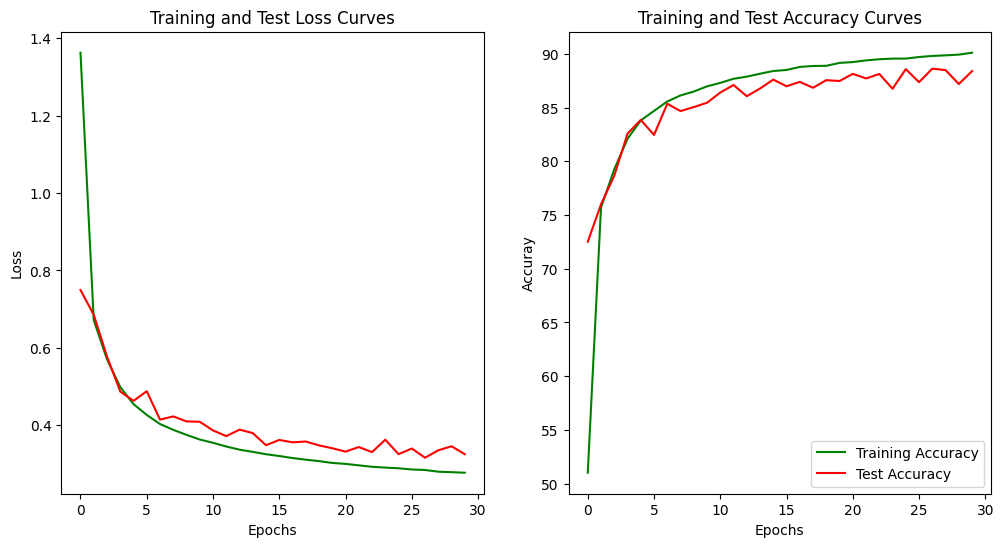

In [18]:
plt.figure(figsize=(12,6))

# subplot 1
plt.subplot(1,2,1) 
plt.title("Loss")
plt.plot(epochs_ctr, avg_tr_loss_per_batch_list, "g", label = "Training Loss")
plt.plot(epochs_ctr, avg_test_loss_per_batch_list, "r", label = "Test Loss")
plt.title("Training and Test Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# subplot 2
plt.subplot(1,2,2)
plt.title("Test")
plt.title("Accuracy")
plt.plot(epochs_ctr, avg_tr_acc_per_batch_list, "g", label = "Training Accuracy")
plt.plot(epochs_ctr, avg_test_acc_per_batch_list, "r", label = "Test Accuracy")
plt.title("Training and Test Accuracy Curves")
plt.xlabel("Epochs")
plt.ylabel("Accuray")

plt.legend()
plt.show()

As seen above, our CNN-based model has beaten the test acccuracy of the previous FCN-based model.

#### Visualize the predictions.
Write a function that returns that prediction probabilities of the passed image samples.

In [19]:
def make_predictions(model: torch.nn.Module,
                    data: list,
                    device: torch.device):
    pred_probs = []
    model.to(device=device)
    model.eval()

    with torch.inference_mode():

        for sample in data:

            # add the batch dimension and pass to target device
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # forward pass
            pred_logit = model(sample)
            
            # get pred prob
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # move the pred_prob to cpu
            pred_probs.append(pred_prob.to("cpu"))
        
    # create a list of tensors
    return torch.stack(pred_probs)

In [24]:
import random
# not setting seeds here
#set_seeds(42)

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k = 9):
    test_samples.append(sample)
    test_labels.append(label)

Text(0.5, 1.0, 'Ankle boot')

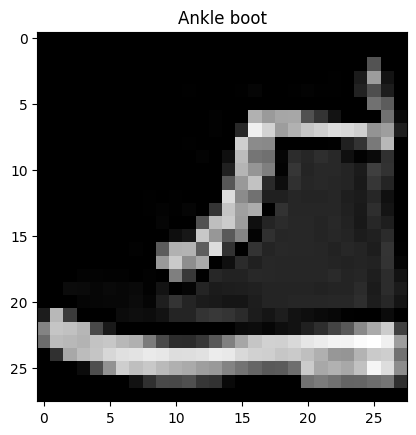

In [25]:
plt.imshow(test_samples[0].squeeze(), cmap = "gray")
plt.title(class_names[test_labels[0]])

Make predictions of random samples.

In [26]:
# get pred probabilities
pred_probs = make_predictions(model = classifier,
                                data = test_samples,
                                device = device)
pred_classes = pred_probs.argmax(dim = 1)
pred_classes

tensor([9, 7, 2, 0, 1, 0, 3, 5, 4])

Plot predictions.

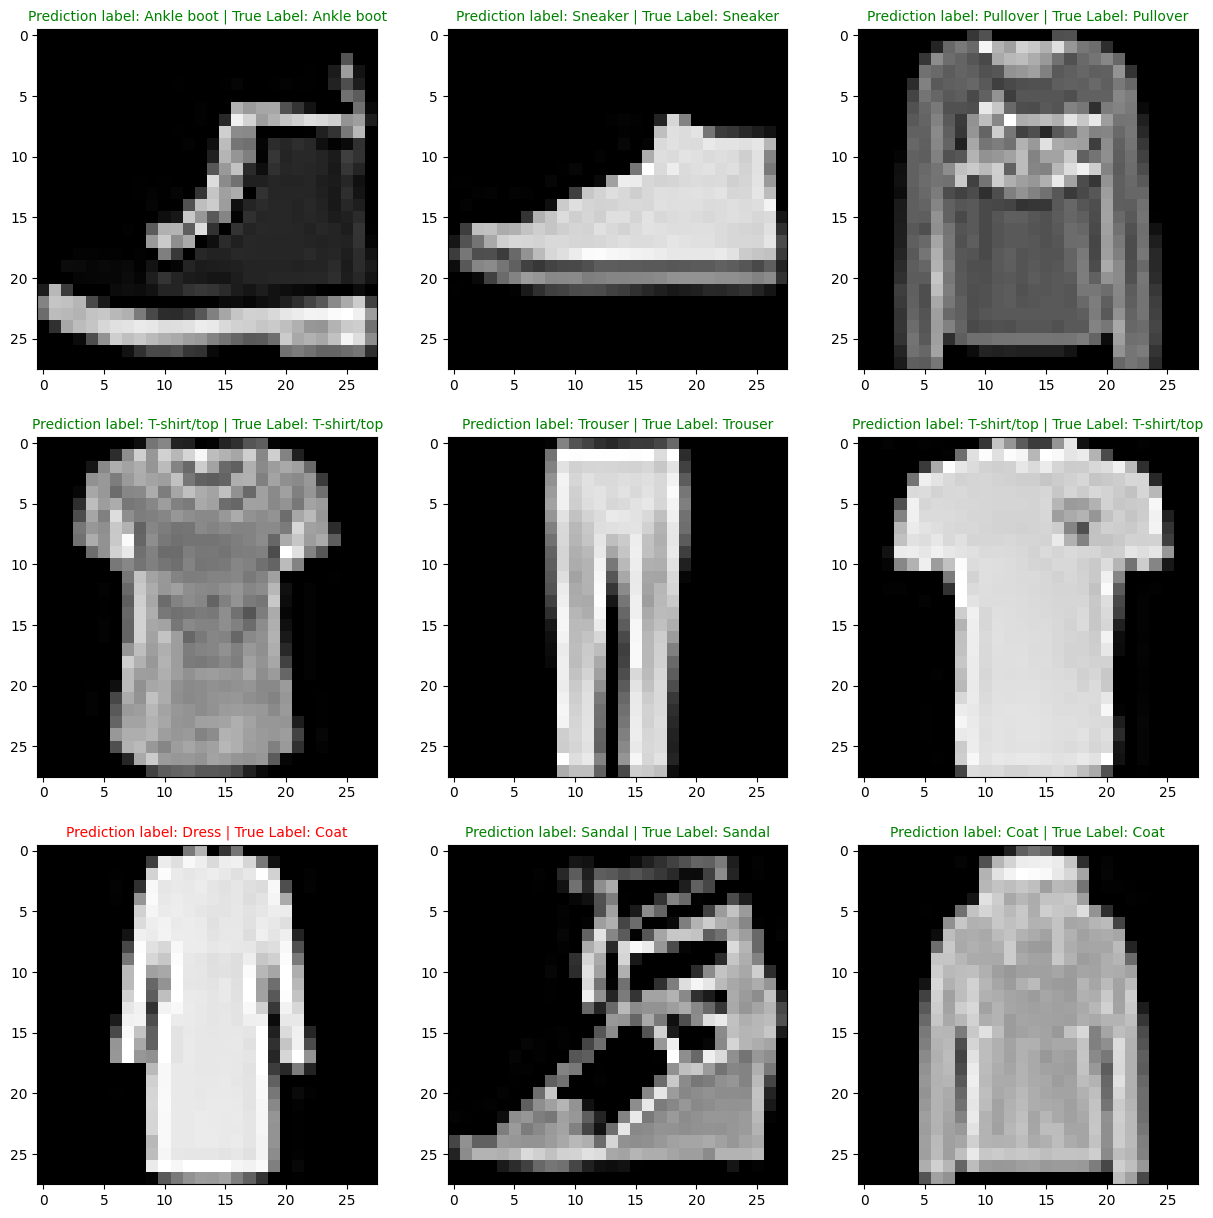

In [27]:
plt.figure(figsize=(15,15))
nrows, ncols = 3,3

for sample_num, sample in enumerate(test_samples):

    # create subplot
    plt.subplot(nrows, ncols, sample_num+1)
    # plot target image
    plt.imshow(sample.squeeze(), cmap="gray")
    # get the prediction
    pred_label = class_names[pred_classes[sample_num]]
    # get the ground truth
    true_label = class_names[test_labels[sample_num]]
    # create title for subplot
    title_text = "Prediction label: {pred_label} | True Label: {true_label}".format(pred_label = pred_label,
                                                                                    true_label = true_label)
    
    # set title color based on if the prediction was correct or not
    if pred_label == true_label:
        plt.title(title_text, fontsize = 10, c = "g")
    else:
        plt.title(title_text, fontsize = 10, c = "r")


The samples were plotted as desired.